In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.interpolation import map_coordinates
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

Setting environment for Precision WorkStation


No vtk
No vtk/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
stack = 'CHATM3'

In [3]:
def resample_scoremap(sparse_scores, sample_locations, gridspec,
                      downscale=None,
                      out_resolution_um=None, 
                      in_resolution_um=None,
                        return_sparse_map=False,
                     interpolation_order=2):
    """
    Resample a dense scoremap based on score at sparse locations.
    
    Note: Make sure `sample_locations` are on the grid specified by `gridspec`.
    
    Args:
        sparse_scores ((n,) float): scores
        sample_locations ((n,2) int): locations of the scores
        gridspec: the tuple (patch size in pixel, spacing in pixel, width, height in pixel)
        downscale (int):
        in_resolution_um (float):
        out_resolution_um (float):
        return_sparse_map (bool): if true, return tuple (dense map, sparse map), else return only dense map.
        
    Returns:
        (2d-array): scoremap over the entire grid
    """

    sample_locations = np.array(sample_locations)
    assert len(sparse_scores) == len(sample_locations)
    
    patch_size_px, spacing_px, w, h = gridspec
    half_size_px = patch_size_px / 2
    
    if downscale is None:
        assert out_resolution_um is not None and in_resolution_um is not None
        downscale = out_resolution_um / in_resolution_um

    downscaled_grid_ys = np.arange(0, h, downscale)
    downscaled_grid_xs = np.arange(0, w, downscale)
    downscaled_ny = len(downscaled_grid_ys)
    downscaled_nx = len(downscaled_grid_xs)
        
    scores_on_unit_grid = np.zeros(((h-half_size_px) / spacing_px + 1, (w-half_size_px) / spacing_px + 1))
    sample_locations_unit_grid = (sample_locations - half_size_px) / spacing_px
    scores_on_unit_grid[sample_locations_unit_grid[:,1], sample_locations_unit_grid[:,0]] = sparse_scores
    
    out_ys_on_unit_grid = (downscaled_grid_ys - half_size_px) / float(spacing_px)
    out_xs_on_unit_grid = (downscaled_grid_xs - half_size_px) / float(spacing_px)

    points_y, points_x = np.broadcast_arrays(out_ys_on_unit_grid.reshape(-1,1), out_xs_on_unit_grid)
    out_yxs_on_unit_grid = np.c_[points_y.flat, points_x.flat]
    f_interp = map_coordinates(scores_on_unit_grid, out_yxs_on_unit_grid.T, 
                               order=interpolation_order, 
                               prefilter=False)
    dense_scoremap = f_interp.reshape((downscaled_ny, downscaled_nx))

    if return_sparse_map:
        return dense_scoremap, scores_on_unit_grid
    else:
        return dense_scoremap

In [4]:
# convert_frame_and_resolution(np.array([[1000, 400, 279], [1000, 401, 279]]), 
#                              in_wrt='alignedPadded', 
#                              in_resolution='image_image_section', 
#                              out_wrt='raw', 
#                              out_resolution='image_image_section',
#                              in_image_resolution='down32',
#                              out_image_resolution='down32',
#                             stack=stack)

In [ ]:
for section in metadata_cache['valid_sections'][stack]:
# for sec in range(150, 170):
# for section in [279]:
    
    print section
    
    t = time.time()
    
    img = DataManager.load_image_v2(stack=stack, prep_id=None, section=section, version='Ntb', resol='raw')

    sys.stderr.write('Load image: %.2f seconds.\n' % (time.time() - t)) # 70s

    t = time.time()
    tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=None, section=section)
    raw_mask = rescale_by_resampling(tb_mask, new_shape=(img.shape[1], img.shape[0]))
    sys.stderr.write('Rescale mask: %.2f seconds.\n' % (time.time() - t)) # 70s

    t = time.time()
    
    mean_std_all_regions = []
    cx_cy_all_regions = []
    region_size = 5000
    region_spacing = 3000
    for cx in range(region_size/2, img.shape[1]-region_size/2+1, region_spacing):
        for cy in range(region_size/2, img.shape[0]-region_size/2+1, region_spacing):
            region = img[cy-region_size/2:cy+region_size/2+1, cx-region_size/2:cx+region_size/2+1]
            region_mask = raw_mask[cy-region_size/2:cy+region_size/2+1, cx-region_size/2:cx+region_size/2+1]
            if np.count_nonzero(region_mask) == 0:
                continue
            mean_std_all_regions.append((region[region_mask].mean(), region[region_mask].std()))
            cx_cy_all_regions.append((cx, cy))
            
    sys.stderr.write('Compute mean/std for sample regions: %.2f seconds.\n' % (time.time() - t)) # 70s
    
    t = time.time()
    mean_map = resample_scoremap(sparse_scores=np.array(mean_std_all_regions)[:,0], 
                             sample_locations=cx_cy_all_regions,
                             gridspec=(region_size, region_spacing, img.shape[1], img.shape[0]),
                            downscale=4, 
                                 interpolation_order=2)

    sys.stderr.write('Interpolate mean map: %.2f seconds.\n' % (time.time() - t)) #10s

    t = time.time()
    mean_map = rescale_by_resampling(mean_map, new_shape=(img.shape[1], img.shape[0]))
    sys.stderr.write('Scale up mean map: %.2f seconds.\n' % (time.time() - t)) #30s


    t = time.time()
    std_map = resample_scoremap(sparse_scores=np.array(mean_std_all_regions)[:,1], 
                             sample_locations=cx_cy_all_regions,
                             gridspec=(region_size, region_spacing, img.shape[1], img.shape[0]),
                            downscale=4,
                               interpolation_order=2)
    sys.stderr.write('Interpolate std map: %.2f seconds.\n' % (time.time() - t)) #10s

    t = time.time()
    std_map = rescale_by_resampling(std_map, new_shape=(img.shape[1], img.shape[0]))
    sys.stderr.write('Scale up std map: %.2f seconds.\n' % (time.time() - t)) #30s
    
    # Save mean/std results.
    
    fp = DataManager.get_intensity_normalization_result_filepath(what='region_centers', stack=stack, section=section)
    create_parent_dir_if_not_exists(fp)    
    np.savetxt(fp, cx_cy_all_regions)
    
    fp = DataManager.get_intensity_normalization_result_filepath(what='mean_std_all_regions', stack=stack, section=section)
    create_parent_dir_if_not_exists(fp)
    np.savetxt(fp, mean_std_all_regions)
    
    fp = DataManager.get_intensity_normalization_result_filepath(what='mean_map', stack=stack, section=section)
    create_parent_dir_if_not_exists(fp)
    bp.pack_ndarray_file(mean_map.astype(np.float16), fp)
    
    fp = DataManager.get_intensity_normalization_result_filepath(what='std_map', stack=stack, section=section)
    create_parent_dir_if_not_exists(fp)
    bp.pack_ndarray_file(std_map.astype(np.float16), fp)

    # Export normalized image.
    
    t = time.time()
    valid_mask = std_map > 0
    img_normalized = np.zeros(img.shape, np.float32)
    img_normalized[valid_mask] = (img[valid_mask] - mean_map[valid_mask]) / std_map[valid_mask]
    sys.stderr.write('Normalize: %.2f seconds.\n' % (time.time() - t)) #30s

    t = time.time()
    img_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, version='NtbNormalizedFloat', resol='down8', section=section)
    create_parent_dir_if_not_exists(img_fp)
    imsave(img_fp, img_normalized[::8, ::8].astype(np.float16))
    sys.stderr.write('Save float version: %.2f seconds.\n' % (time.time() - t)) #30s
        
    t = time.time()
    img_normalized_uint8 = rescale_intensity_v2(img_normalized, -1, 6)
    sys.stderr.write('Rescale to uint8: %.2f seconds.\n' % (time.time() - t)) #30s
    
    t = time.time()
    img_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, version='NtbNormalized', resol='raw', section=section)
    create_parent_dir_if_not_exists(img_fp)
    imsave(img_fp, img_normalized_uint8)
    sys.stderr.write('Save uint8 version: %.2f seconds.\n' % (time.time() - t)) #30s
    
    # Export histogram.
    
    hist_fp = DataManager.get_intensity_normalization_result_filepath(what='float_histogram', stack=stack, section=section)
    create_parent_dir_if_not_exists(hist_fp)
    
    hist, bin_edges = np.histogram(img_normalized[valid_mask].flatten(), bins=np.arange(0,201,5));

    plt.bar(bin_edges[:-1], np.log(hist));
    plt.xticks(np.arange(0, 200, 20), np.arange(0, 200, 20));
    plt.xlabel('Normalized pixel value (float)');
    plt.title(metadata_cache['sections_to_filenames'][stack][section])

    plt.savefig(hist_fp)
    plt.close();

79


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_raw_Ntb/CHATM3_slide27_2018_02_17-S2_raw_Ntb.tif


Load image: 1.53 seconds.
Rescale mask: 11.81 seconds.
Compute mean/std for sample regions: 9.76 seconds.
Interpolate mean map: 5.71 seconds.
Scale up mean map: 12.82 seconds.
Interpolate std map: 5.55 seconds.
Scale up std map: 13.52 seconds.
Normalize: 12.88 seconds.
Save float version: 0.55 seconds.
Rescale to uint8: 14.38 seconds.
Save uint8 version: 8.39 seconds.


80


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_raw_Ntb/CHATM3_slide28_2018_02_17-S2_raw_Ntb.tif


Load image: 1.34 seconds.
Rescale mask: 9.69 seconds.
Compute mean/std for sample regions: 10.71 seconds.
Interpolate mean map: 4.62 seconds.
Scale up mean map: 11.74 seconds.
Interpolate std map: 4.66 seconds.
Scale up std map: 11.42 seconds.
Normalize: 11.13 seconds.
Save float version: 0.52 seconds.
Rescale to uint8: 13.43 seconds.
Save uint8 version: 8.41 seconds.


81


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_raw_Ntb/CHATM3_slide27_2018_02_17-S3_raw_Ntb.tif


Load image: 13.15 seconds.
Rescale mask: 11.33 seconds.
Compute mean/std for sample regions: 11.64 seconds.
Interpolate mean map: 5.33 seconds.
Scale up mean map: 12.60 seconds.
Interpolate std map: 5.20 seconds.
Scale up std map: 12.37 seconds.
Normalize: 12.06 seconds.
Save float version: 0.61 seconds.
Rescale to uint8: 14.17 seconds.
Save uint8 version: 8.28 seconds.


82


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_raw_Ntb/CHATM3_slide28_2018_02_17-S3_raw_Ntb.tif


Load image: 13.46 seconds.
Rescale mask: 10.48 seconds.
Compute mean/std for sample regions: 11.11 seconds.
Interpolate mean map: 4.60 seconds.
Scale up mean map: 11.38 seconds.
Interpolate std map: 4.60 seconds.
Scale up std map: 11.68 seconds.
Normalize: 12.10 seconds.
Save float version: 0.55 seconds.
Rescale to uint8: 13.41 seconds.
Save uint8 version: 9.54 seconds.


83


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_raw_Ntb/CHATM3_slide29_2018_02_17-S1_raw_Ntb.tif


Load image: 13.46 seconds.
Rescale mask: 10.73 seconds.
Compute mean/std for sample regions: 12.17 seconds.
Interpolate mean map: 5.15 seconds.
Scale up mean map: 12.53 seconds.
Interpolate std map: 5.13 seconds.
Scale up std map: 12.22 seconds.
Normalize: 13.02 seconds.
Save float version: 0.57 seconds.
Rescale to uint8: 14.00 seconds.
Save uint8 version: 9.76 seconds.


84


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_raw_Ntb/CHATM3_slide30_2018_02_17-S1_raw_Ntb.tif


Load image: 14.35 seconds.
Rescale mask: 13.20 seconds.
Compute mean/std for sample regions: 13.41 seconds.
Interpolate mean map: 5.88 seconds.
Scale up mean map: 13.86 seconds.
Interpolate std map: 5.91 seconds.
Scale up std map: 14.42 seconds.
Normalize: 15.36 seconds.
Save float version: 0.70 seconds.
Rescale to uint8: 17.44 seconds.
Save uint8 version: 9.83 seconds.


85


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_raw_Ntb/CHATM3_slide29_2018_02_17-S2_raw_Ntb.tif


Load image: 13.35 seconds.
Rescale mask: 11.27 seconds.
Compute mean/std for sample regions: 12.11 seconds.


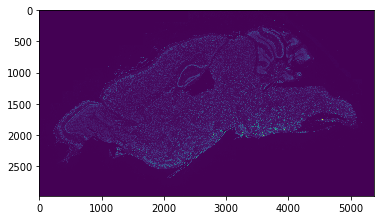

In [12]:
plt.imshow(img[::10, ::10]);

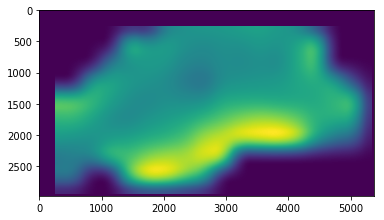

In [13]:
plt.imshow(mean_map[::10, ::10]);
# plt.colorbar();

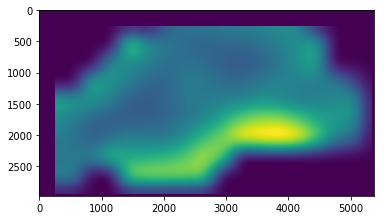

In [14]:
plt.imshow(std_map[::10, ::10]);
# plt.colorbar();

In [9]:
valid_mask = std_map > 0

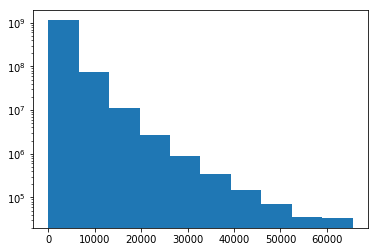

In [50]:
plt.hist(img[valid_mask], log=True);

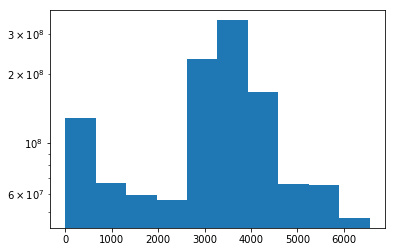

In [51]:
plt.hist(mean_map[valid_mask], log=True);

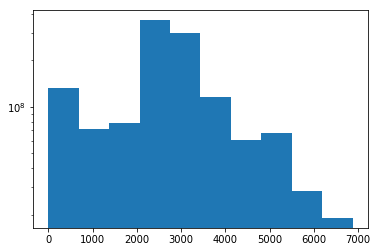

In [52]:
plt.hist(std_map[valid_mask], log=True);

In [15]:
img_normalized = np.zeros(img.shape, np.float32)
img_normalized[valid_mask] = (img[valid_mask] - mean_map[valid_mask]) / std_map[valid_mask]

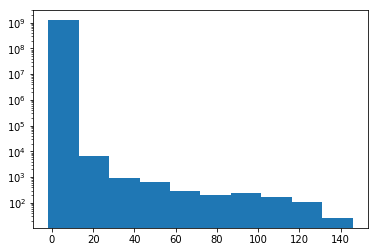

In [54]:
plt.hist(img_normalized[valid_mask], log=True);

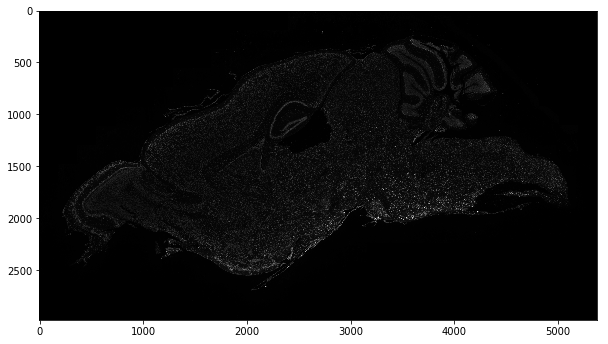

In [55]:
plt.figure(figsize=(10,10));
plt.imshow(img[::10, ::10], cmap=plt.cm.gray);

In [56]:
img_normalized_uint8 = rescale_intensity_v2(img_normalized, -1, 6)

In [57]:
cx_cy_all_regions = np.array(cx_cy_all_regions)

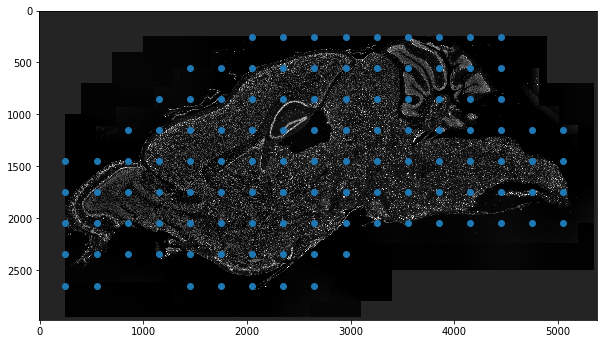

In [58]:
plt.figure(figsize=(10,10));
plt.imshow(img_normalized_uint8[::10, ::10], cmap=plt.cm.gray);
plt.scatter(cx_cy_all_regions[:,0]/10, cx_cy_all_regions[:,1]/10);

In [ ]:
display_image(img_normalized_uint8)

In [ ]:
image_identifiers = [('CHATM2', 'CHATM2_slide27_2018_01_18-S1', 'Ntb')  
#     ('CHATM2', 'CHATM2_slide66_2018_02_14-S2', 'Ntb'), #195
#  ('MD589', 'MD589-IHC38-2015.07.30-23.54.24_MD589_2_0113', 'blue'),
#                       ('CHATM2', 'CHATM2_slide66_2018_02_14-S3', 'Ntb'),
# ('MD589', 'MD589-N39-2015.07.30-18.40.43_MD589_1_0115', 'blue'),
#                       ('CHATM2', 'CHATM2_slide68_2018_02_14-S1', 'Ntb'),
#  ('MD589', 'MD589-N39-2015.07.30-18.40.43_MD589_2_0116', 'blue'),
#                       ('CHATM2', 'CHATM2_slide68_2018_02_14-S2', 'Ntb'),
#  ('MD589', 'MD589-N40-2015.07.30-18.44.48_MD589_2_0119', 'blue'),
#                       ('CHATM2', 'CHATM2_slide70_2018_02_14-S1', 'Ntb'),
#  ('MD589', 'MD589-N41-2015.07.30-18.48.44_MD589_1_0121', 'blue')#208
    ]

In [ ]:
window_size_um = 3000
window_spacing_um = 1000

In [ ]:
for stack, fn, version in image_identifiers:
    
    NorF = DataManager.get_brightfield_or_fluorescence(stack=stack, fn=fn)
    
    img = DataManager.load_image_v2(stack=stack, prep_id=2, fn=fn, version=version)
    img = img[::8, ::8]
    
    window_size_px = int(window_size_um / planar_resolution[stack]) / 8
    window_spacing_px = int(window_spacing_um / planar_resolution[stack]) / 8
    
    img_after_normalization = normalize_image(img, window_size=window_size_px, window_spacing=window_spacing_px)
    
    if NorF == 'N':
        vmin = -6
        vmax = 1
        img_before_normalization = rescale_intensity_v2(img, img.min(), img.max())
    else:
        vmin = 6 
        vmax = -1
        img_before_normalization = rescale_intensity_v2(img, img.max(), img.min())
    
    img_before_normalization_ubyte = rescale_intensity_v2(img_before_normalization, 0, 255)
    img_after_normalization_ubyte = rescale_intensity_v2(img_after_normalization, vmin, vmax)
    
    plt.figure(figsize=(20,20));
    plt.imshow(img_before_normalization_ubyte, cmap=plt.cm.gray, vmin=0, vmax=255);
    plt.title('%s, before normalization' % fn);
    plt.show();
    
    plt.figure(figsize=(20,20));
    plt.imshow(img_after_normalization_ubyte, cmap=plt.cm.gray, vmin=0, vmax=255);
    plt.title('%s, after normalization' % fn);
    plt.show();

In [ ]:
def normalize_image(img, window_size=3000, window_spacing=1000):
    
    img_calib = np.zeros(img.shape, np.float)

    for cx in range(window_size/2, img.shape[1], window_spacing):
        for cy in range(window_size/2, img.shape[0], window_spacing):
    #         mu, std = mean_std_sample_locations[(cx, cy)]
            mu = img[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1].mean()
            std = img[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1].std()
            print cx, cy, mu, std
            
            if std > 0:            
#                 img_calib[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1] = \
#                 .5 * img_calib[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1] + \
#                 .5 * (img[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1] - mu) / std
    
                img_calib[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1] = \
                (img[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1] - mu) / std
    return img_calib

In [ ]:
stack = 'CHATM2'

# for fn in metadata_cache['valid_filenames'][stack]:
for fn in ['CHATM2_slide27_2018_01_18-S2']:

    print fn
    
    img = DataManager.load_image_v2(stack=stack, prep_id=2, version='Ntb', fn=fn)
    
    window_size_px = int(window_size_um / planar_resolution[stack])
    window_spacing_px = int(window_spacing_um / planar_resolution[stack])
    
    img_after_normalization = normalize_image(img, window_size=window_size_px, window_spacing=window_spacing_px)
    
    vmin = 6 
    vmax = -1
    img_after_normalization_ubyte = rescale_intensity_v2(img_after_normalization, vmin, vmax)
    
    plt.figure(figsize=(20,20));
    plt.imshow(img_after_normalization_ubyte, cmap=plt.cm.gray, vmin=0, vmax=255);
    plt.title('%s, after normalization' % fn);
    plt.show();
    
#     fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=2, version='NtbWinNormalized', fn=fn)
#     create_parent_dir_if_not_exists(fp)
#     imsave(fp, img_after_normalization_ubyte)